## Introduction to Power Network Analysis with Pandapower
##### Xiangyue Wang, Thomas Morstyn

**Pandapower** is a popular open-sourced python package for power system modeling and optimization. Its name originates from the data analysis library, **pandas**, and the power flow solver library, **PYPOWER**. Pandapower combines the data structure of the former with solvers from the latter to:

- conduct static analysis of **three-phase distribution systems**, which are commonly found in Europe
- solve **AC and DC optimal power flow** problems
- conduct state estimation, static short-circuit simulation, and topological search.



As of Feburary, 2025, Pandapower **cannot** analyse distribution grids with unsymmetrical power lines design, such as the feeder design common in North America. It also cannot solved unbalanced power flow problems and conduct dynamic short-circuit simulation.

In this notebook, we will walk you through how to use pandapower for power flow optimization.

### Installation

In [ ]:
pip install pandapower

Pandapower recommends installing the package in an Anaconda environment, which has all the other dependencies that pandapower requires. The command above could result in an error if you are starting a new virtual environment without nothing else installed. In that case, use the **requirements.txt** file I included in the repository to install pandapower together with some necessary packages such as numpy and pandas.

In [ ]:
# pip install requirements.txt

### First Example: Power Flow Modeling Review

Recall that electric systems almost everywhere involve sinusoidally varying AC voltages and currents. In other words,
$$ V(t) = V_{max} sin(\omega t+\theta_v)$$
$$ I(t) = I_{max} sin(\omega t+\theta_i)$$
where $\theta_v, \theta_i$ are phase angles, and $\omega$ is the angular frequency (50 Hz or 100 times of direction change per second for Europe). We are interested in steady state conditions at this fixed frequency since this is where normal power system operation takes place. **Specifically, we wish to find the voltage magnitude and voltage angle across the network given a set of generators and loads.**

In DC Power Flow Modeling, we are particularly concerned with the voltage angle difference between buses. For convenience, we set all voltage angles as the difference relative to a reference bus (called the **slack bus**, normally the largest generator for transmission network), whose angle is conventionally set to zero.

For example, if you have two voltage signals:

Bus 1 voltage: $V_1=V_{max}sin⁡(ωt)$

Bus 2 voltage: $V_2=V_{max}sin⁡(ωt−10\degree)$

The voltage angle of Bus 2 is -10° relative to Bus 1, or $V_2 = V_{max}\angle -10\degree$.
Note that voltage angles aren't physical angles of objects. Instead, they're determined indirectly using Phasor Measurement Units (PMUs), which measure precise time-stamped voltage and current waveforms at buses. Just as water moves from higher to lower pressure, electric power flows from higher voltage angle (sources) to lower voltage angle (loads). 

In DC Power Flow, we assume nodes have small voltage angle differences and small voltage drops (typically true for transmission) in order to linearize the sinusoidal AC voltage. For DC power flow, the power flow from bus k to j is

$$P_{kj} = \frac{1}{x_{kj}}(\theta_k - \theta_j) = B_{kj}(\theta_k - \theta_j)$$

where $x_{kj}$ is the line reactance and $B_{kj}$ is the line suceptance, or the kj-th entry of the admittance matrix.

Recall this example from the lecture:

![example_1.png](images/example_1.png)

where **pu** stands for **per unit** to simplify the calculation. Let's try to replicate this grid in pandapower. 
### How to Make a Grid in Pandapower
First, we import pandapower as **pp** and create an empty network using **pp.create_empty_network()**.

In [1]:
import pandapower as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandapower.plotting as plot

# Create an empty network
net1 = pp.create_empty_network()

Then, we create the buses using **create_bus**. Since the example is in a per unit system with no base unit specified, we will go ahead and assume the base voltage is 110 kV and the base active power is 100 MV.

In [2]:
# Set base values for the per unit system
base_kV = 110.0 # Base voltage in kV
base_MV = 100  # Base active power

#Create the buses
bus1 = pp.create_bus(net1, vn_kv=base_kV, name="Bus 1")
bus2 = pp.create_bus(net1, vn_kv=base_kV, name="Bus 2")
bus3 = pp.create_bus(net1, vn_kv=base_kV, name="Bus 3")

#Show the bus table
net1.bus 

,name,vn_kv,type,zone,in_service
0,Bus 1,110.0,b,None,True
1,Bus 2,110.0,b,None,True
2,Bus 3,110.0,b,None,True


Now, let's add the generators using **create_gen**. The diagram shows two generators. The first generator is connected to the slack bus, hence we set it as the slack generator with voltage magnitude (vm_pu) of 1 per unit. 

Even when the generator is a slack, we still need to give it an initial guess for p_mw, the active power. 0 is normally fine, because pandapower will calculate the actual value during the power flow. From the problem, we also know that generator 2 has p_mw of 1 per unit and reactive power (q_mvar) of 0.5 per unit.

In [3]:
#Create the generators
pp.create_gen(net1, bus=bus1, p_mw=0, vm_pu=1.0, slack=True, name="Generator 1")
pp.create_gen(net1, bus=bus2, p_mw=base_MV, q_mvar=0.5*base_MV, min_p_mw=0, max_p_mw=110, name="Generator 2")


1

Now, let's add the loads. We know that the load connected to bus 3 has active power of 2 per unit and reactive power of 0.5 per unit. 

In [4]:
#Create the loads
pp.create_load(net1, bus=bus3, p_mw=2*base_MV, q_mvar=0.5*base_MV, name="L3")

#Show the load table
net1.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,L3,2,200.0,50.0,0.0,0.0,NaN,1.0,True,wye


Lastly, let's add the lines. From the problem, we know that
$$z_{12} = 0.001 + j0.01 pu$$
$$z_{13} = 0.001 + j0.01 pu$$

meaning that each line has resistance (R) of 0.001 pu and reactance (X) of 0.01 pu. To add those lines, we need to convert per unit to Ohms by determining the base impedance:

$$Z_{base} = \frac{V^2_{base}}{S_{base}}$$

In [5]:
# Compute Base Impedance
z_base = base_kV**2 / base_MV  # in Ohms

# Line Impedances in Ohms
r_ohm = 0.001*z_base
x_ohm = 0.01*z_base

# Create the specific line used in Example 1
example1_line = {"r_ohm_per_km": r_ohm, "x_ohm_per_km": x_ohm, "c_nf_per_km": 10, "max_i_ka": 0.4, "type": "cs"}
pp.create_std_type(net1, name="example1_line", data=example1_line, element="line")
pp.available_std_types(net1, element="line")

length_km = 1  # nominal length

pp.create_line(net1, from_bus=bus1, to_bus=bus2, length_km=length_km, std_type="example1_line", name="line12")
pp.create_line(net1, from_bus=bus1, to_bus=bus3, length_km=length_km, std_type="example1_line", name="line13")

1

Now, let's have a look at the grid we created.

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


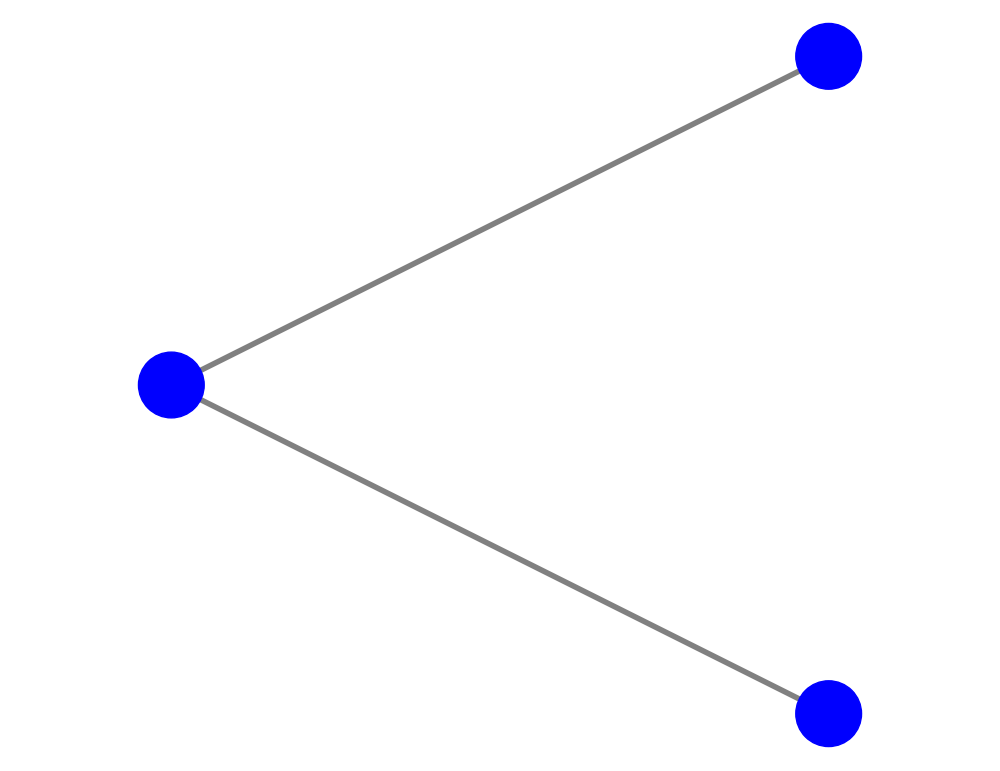

<Axes: >

In [6]:
#Show the Example 1 grid
plot.simple_plot(net1, show_plot=True, line_width=4, bus_size=5)

Let's go back to the question:

![example_1.png](images/example_1.png)

Recall how we would solve this problem analytically:

$$
\begin{bmatrix}
P_1\\
P_2\\
\vdots\\
P_N
\end{bmatrix}=\bold{B}\begin{bmatrix}
\theta_1\\
\theta_2\\
\vdots\\
\theta_N
\end{bmatrix}=
\begin{bmatrix}
B_{12} + B_{13} + \dots + B_{1N} & -B_{12}                 & \dots & -B_{1N}\\
-B_{21}                          & B_{21} + B_{22} + \dots + B_{2N} & \dots & -B_{2N}\\
\vdots                           & \vdots                           & \ddots & \vdots\\
-B_{N1}                          & -B_{N2}                          & \dots & B_{N1} + B_{N2} + \dots
\end{bmatrix}
\begin{bmatrix}
\theta_1\\
\theta_2\\
\vdots\\
\theta_N
\end{bmatrix}
$$

where $B_{ij} = \frac{1}{x_{ij}}$

Write the admittance matrix B for this problem and solve analytically:

Now, we will solve the DC power flow using pandapower's DC power flow solver.

In [7]:
#DC Power Flow
pp.rundcpp(net1)
print(net1.res_bus)


   vm_pu  va_degree   p_mw  q_mvar
0    1.0   0.000000 -100.0     NaN
1    1.0   0.572958 -100.0     NaN
2    1.0  -1.145916  200.0     NaN


We can also solve the same grid using the Balanced AC Power flow function.

In [8]:
# Run balanced AC power flow
pp.runpp(net1)
print(net1.res_bus)

      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -100.532105 -64.754756
1  1.000000   0.578405 -100.000000   9.509458
2  0.992758  -1.125501  200.000000  50.000000


### Second Example: Optimal Power Flow
Let's look at another example from the lecture. 
![example_2.png](images/example_2.png)

This time we are trying to optimize the power flow based on the cost of generation for each generator. 

Try creating an empty network and adding the generators and load yourself.


In [9]:
# Create an empty network
net2 = pp.create_empty_network()

# Set base values for the per unit system
base_kV = 110 # Base voltage in kV
base_MVA = 100 # Base apparent power

#Create the buses
b1 = pp.create_bus(net2, vn_kv=base_kV, name="Bus 1")
b2 = pp.create_bus(net2, vn_kv=base_kV, name="Bus 2")
b3 = pp.create_bus(net2, vn_kv=base_kV, name="Bus 3")

#Create the generators 
gen1 = pp.create_gen(net2, bus=b1,  p_mw=0, min_p_mw=0, max_p_mw=300, vm_pu=1.0, slack=True, name="Generator 1")
gen2 = pp.create_gen(net2, bus=b2, p_mw=0, min_p_mw=0, max_p_mw=300, name="Generator 2")
gen3 = pp.create_gen(net2, bus=b3, p_mw=0, min_p_mw=0, max_p_mw=300, name="Generator 3")

# Add generator costs
pp.create_poly_cost(net2, element=gen1, et='gen', cp1_eur_per_mw=20)
pp.create_poly_cost(net2, element=gen2, et='gen', cp1_eur_per_mw=30)
pp.create_poly_cost(net2, element=gen3, et='gen', cp1_eur_per_mw=100)

#Create the loads
pp.create_load(net2, bus=b2, p_mw=3*base_MVA, q_mvar=0.5*base_MVA, name="L2")


0

Now, we need to add the lines with the specific powerflow limits. To add the limits, we need to convert the power limit into current limit. Recall that apparent power (S) in a three-phase system is given by
$$S = \sqrt{3}VI$$
$$I = \sqrt{3}VS$$
We will create a function **mw_to_ka** to do so.

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


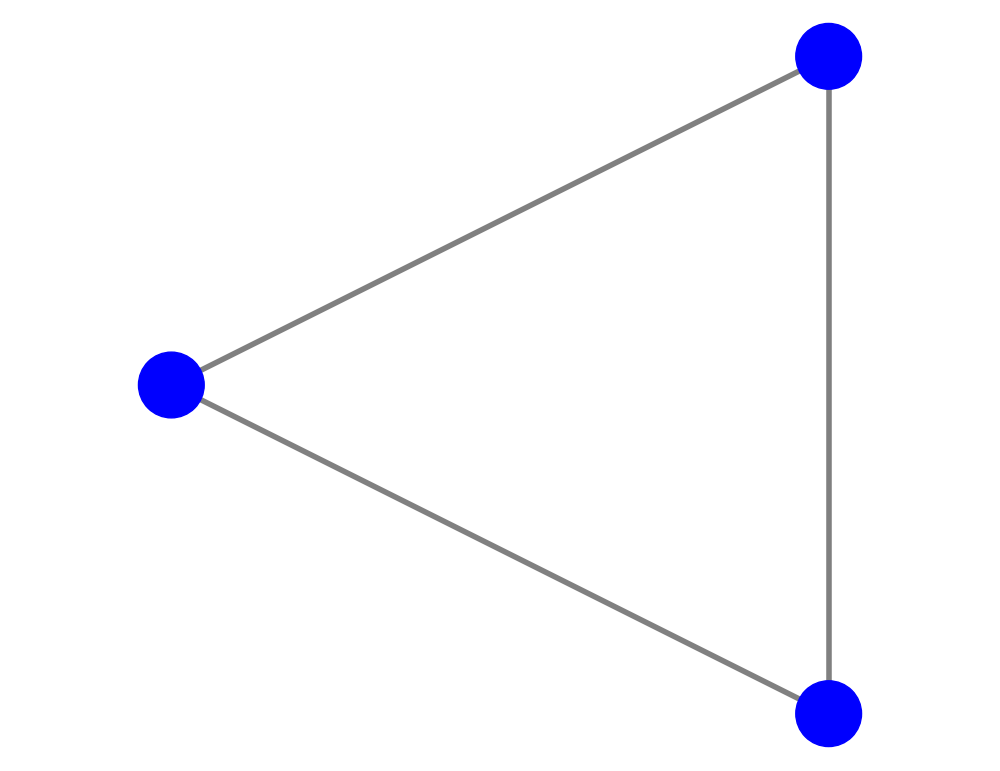

<Axes: >

In [10]:
# Compute Base Impedance
z_base = base_kV**2 / base_MVA  # in Ohms

# Line Impedances in Ohms
r_ohm = 0 # Since we don't have the info, let's assume we have negligible resistance
x_ohm = 0.5*z_base

length_km = 1  # nominal length

#Convert line flow limits from MW to kA (approx)
def mw_to_ka(p_mw, v_kv=base_kV):
    return p_mw / (v_kv * (3)**0.5)

# Add lines with limits
pp.create_line_from_parameters(net2, b1, b2, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(200), name="line12")

pp.create_line_from_parameters(net2, b1, b3, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(200), name="line13")

pp.create_line_from_parameters(net2, b2, b3, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(50), name="line23")

#Show the Example 2 grid
plot.simple_plot(net2, show_plot=True, plot_loads=True, plot_gens=True, line_width=4, bus_size=5)

In [11]:
# Run DC Optimal Power Flow
pp.rundcopp(net2)
print(net2.res_bus)


   vm_pu  va_degree          p_mw  q_mvar      lam_p  lam_q
0    1.0   0.000000 -3.000000e+02     NaN  27.364717    0.0
1    1.0 -57.295779  3.000000e+02     NaN  27.364717    0.0
2    1.0 -28.647890 -8.791375e-08     NaN  27.364717    0.0


In [12]:
# Run AC Optimal Power Flow
pp.runopp(net2)
print(net2.res_bus)

AttributeError: 'csc_matrix' object has no attribute 'H'

### Third Example: Great Britain Network

For our third example, let's look at a commonly used network available in pandapower.  The Great Britain (GB) Network represents the UK electricity transmission network. It consists of 2224 nodes, 3207 branches and 394 generators. We will import it from **pandapower.networks**, which contains a set of other useful grids. You can find out about them [here.](https://pandapower.readthedocs.io/en/v2.0.0/networks/power_system_test_cases.html#case-gb-network)

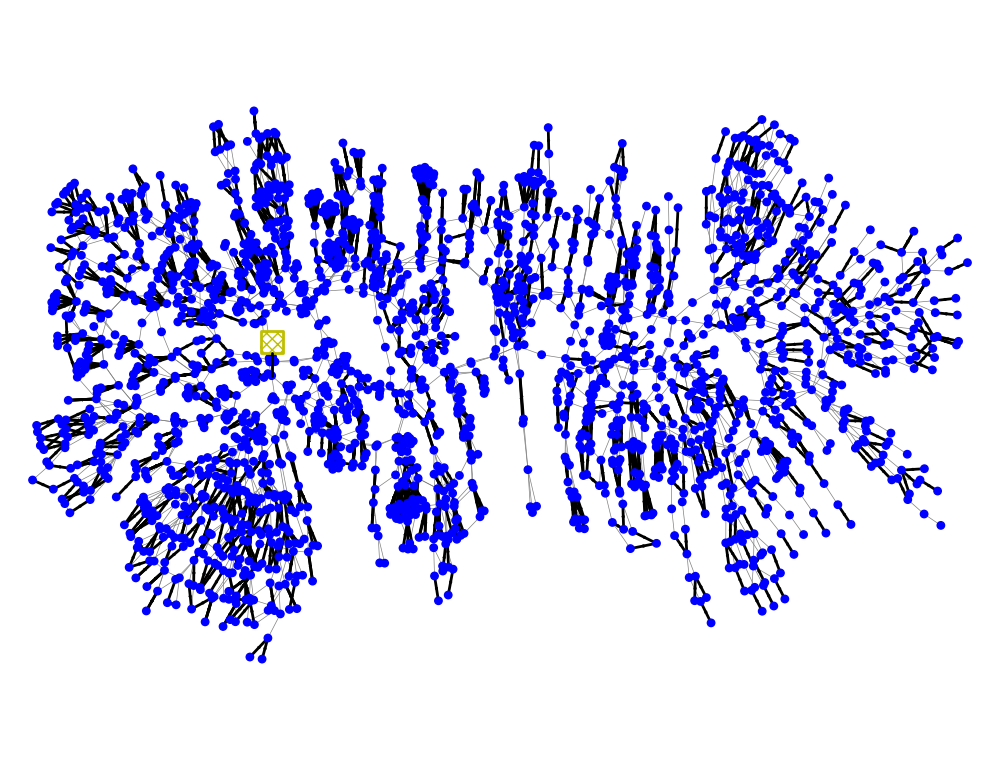

This pandapower network includes the following parameter tables:
   - bus (2224 elements)
   - load (446 elements)
   - sgen (37 elements)
   - gen (393 elements)
   - shunt (253 elements)
   - ext_grid (1 element)
   - line (1557 elements)
   - trafo (1650 elements)
   - poly_cost (394 elements)
   - bus_geodata (2224 elements)

In [13]:
import pandapower.networks as pn
net3 = pn.GBnetwork()
plot.simple_plot(net3, show_plot=True, trafo_size=0.02, line_width=0.5, bus_size=0.5)
net3


Solve both DC and AC Power flow on this grid. Observe the results describe which generators are used the most.

In [14]:
#DC Power Flow
pp.rundcpp(net3)
print(net3.res_bus)

      vm_pu  va_degree      p_mw  q_mvar
0      1.00  -0.078278    0.0000     NaN
1      1.05   4.585880 -303.7966     NaN
2      1.05   4.630001 -304.3822     NaN
3      1.05   4.580025 -303.9515     NaN
4      1.00   2.404464    0.0000     NaN
5      1.05  15.126532 -191.2500     NaN
6      1.05  15.147639 -191.2500     NaN
7      1.00   4.635445    0.0000     NaN
8      1.05  17.196510 -191.2500     NaN
9      1.05  17.365434 -191.2500     NaN
10     1.05  17.400986 -191.2500     NaN
11     1.05  15.667555 -209.2500     NaN
12     1.05  19.503490 -302.3886     NaN
13     1.00  21.669462    7.7900     NaN
14     1.05  26.508624 -290.4628     NaN
15     1.05  26.414694 -290.1800     NaN
16     1.05  26.429926 -290.4318     NaN
17     1.05  26.404858 -290.3847     NaN
18     1.00  21.937272    0.0000     NaN
19     1.05  33.308558 -290.1997     NaN
20     1.05  33.308558 -290.1997     NaN
21     1.05  27.638771 -144.0000     NaN
22     1.00  -1.674991    0.0000     NaN
23     1.05   3.

In [15]:
#AC Power Flow
pp.runpp(net3)
print(net3.res_bus)

         vm_pu  va_degree        p_mw      q_mvar
0     1.049146  -1.492748    0.000000    0.000000
1     1.050000   2.744717 -303.796600   -0.801296
2     1.050000   2.782936 -304.382200   -8.069981
3     1.050000   2.738842 -303.951500   -2.199417
4     1.040402   0.293650    0.000000    0.000000
5     1.050000  11.977475 -191.250000  -37.723643
6     1.050000  11.997202 -191.250000  -37.726713
7     1.046266   2.308984    0.000000    0.000000
8     1.050000  13.784032 -191.250000  -31.479506
9     1.050000  13.940946 -191.250000  -32.548276
10    1.050000  13.973968 -191.250000  -32.567362
11    1.050000  12.483684 -209.250000  -41.407984
12    1.050000  15.936114 -302.388600  -65.396565
13    1.051057  17.188121    7.790000   21.520000
14    1.050000  21.559421 -290.462800 -111.063962
15    1.050000  21.474215 -290.180000  -69.558888
16    1.050000  21.487925 -290.431800 -104.229341
17    1.050000  21.465161 -290.384700  -95.434238
18    1.046094  16.702510    0.000000    0.000000
